In [30]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from time import time
import lightgbm as lgbm
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [31]:
data0=pd.read_csv("C:/Skola/Examensarbete/footballData.csv")
target_variable = 'value_eur'

from sklearn.preprocessing import LabelEncoder
def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

#Hanterar strängar i columnerna

swedish_allsvenskan_data = data0[data0['league_name'] == 'Swedish Allsvenskan']
data1=labelencoder(swedish_allsvenskan_data)
#data1 = labelencoder(data0)
m=len(data1)
M=list(range(m))
#random.seed(2021)
random.shuffle(M)

df_columns = list(data1.columns)
print(df_columns)

['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob', 'height_cm', 'weight_kg', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_ba

C:\Users\willi\AppData\Local\Temp\ipykernel_15284\2379618306.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].fillna('N')
C:\Users\willi\AppData\Local\Temp\ipykernel_15284\2379618306.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = lbl.transform(df[c].values)
C:\Users\willi\AppData\Local\Temp\ipykernel_15284\2379618306.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [32]:
#Metod för att skapa numeriska features
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [33]:
from tqdm import tqdm

def to_feature(input_df):
    processors = [
        create_numeric_feature,
    ]
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        _df = func(input_df)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df


In [34]:
data = to_feature(data1)
#Räknar antal celler med tomma värden eller NaN
print(data.isnull().sum())
data.head()

100%|██████████| 1/1 [00:00<00:00, 206.80it/s]

sofifa_id     0
player_url    0
short_name    0
long_name     0
age           0
             ..
lb            0
lcb           0
cb            0
rcb           0
rb            0
Length: 106, dtype: int64


,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
1821,176794,16,317,312,33,41,192,78,46,11,...,36,43,43,43,36,34,38,38,38,34
1925,199792,79,14,40,30,115,174,75,12,11,...,62,73,73,73,62,58,68,68,68,58
2553,236823,235,178,179,23,87,181,80,46,8,...,12,17,17,17,12,11,10,10,10,11
2651,209529,120,290,295,25,285,180,74,46,4,...,35,38,38,38,35,33,33,33,33,33
2774,164459,7,365,367,35,85,178,70,46,0,...,60,72,72,72,60,56,62,62,62,56


In [35]:
nans=pd.isnull(data).sum()
nans[nans>0]

release_clause_eur       16
nation_jersey_number    402
pace                     47
shooting                 47
passing                  47
dribbling                47
defending                47
physic                   47
gk_diving               365
gk_handling             365
gk_kicking              365
gk_reflexes             365
gk_speed                365
gk_positioning          365
defending_marking       412
dtype: int64

In [36]:
data = data.drop(["nation_jersey_number", "defending_marking"], axis=1)
data.dtypes.value_counts()


int64      44
int32      44
float64    16
Name: count, dtype: int64

In [37]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
data_filled = imputer.fit_transform(data)
data_filled = pd.DataFrame(data_filled, columns=data.columns)

#Logaritmera data för att minska variansen mot målvariabeln 'value_eur'
sample = ['potential', 'league_rank', 'overall', 'age', 'team_position', 'international_reputation', 'shooting', 'passing']
for col in sample:
    data_filled[col] = np.log1p(data_filled[col])  #np.log1p för att hantera 0 samt negativa logaritmen

train = data_filled.iloc[M[0:(m//4)*3]]
test = data_filled.iloc[M[(m//4)*3:]]

target_variable = 'value_eur'
y_train = train[target_variable]
X_train = train[sample]
y_test = test[target_variable]
X_test = test[sample]

print("Shapes of X_train, y_train, X_test, y_test:")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shapes of X_train, y_train, X_test, y_test:
(309, 8) (309,) (103, 8) (103,)


In [38]:
pca = PCA(whiten=True)
pca.fit(X_train)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

array([0.73666376, 0.90681836, 0.96136658, 0.9835609 , 0.99290317,
       0.99932237, 1.        , 1.        ])

In [39]:
train_data = lgbm.Dataset(X_train, label=y_train.values.ravel())  
eval_data = lgbm.Dataset(X_test, label=y_test.values.ravel(), reference=train_data) 

# Längden av x och y träningsdata
print('Train data x length: ', len(train_data.data))
print('Train data y length: ', len(train_data.label))

# Längden av x och y test data
print('Test data x length: ', len(eval_data.data))
print('Test data y length: ', len(eval_data.label))

Train data x length:  309
Train data y length:  309
Test data x length:  103
Test data y length:  103


In [ ]:
#Antal features som visas
top_n_features = 8

#feature_target_correlation = train.corr()['value_eur'].drop('value_eur')
feature_target_correlation = train[sample + ['value_eur']].corr()['value_eur'].drop('value_eur')
sorted_correlation = feature_target_correlation.abs().nlargest(top_n_features)

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_correlation.values, y=sorted_correlation.index, palette='viridis')
plt.xlabel('Correlation with value_eur')
plt.ylabel('Features')
plt.title(f'Top {top_n_features} Features with Highest Correlation to Target Variable (value_eur)')
plt.show()

In [ ]:
correlation_matrix = X_train.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Features')
plt.show()

In [40]:
#params = {
    #'objective': 'rmse', 
    #'learning_rate': .1,
    #'reg_lambda': 1.,
    #'reg_alpha': .1,
    #'max_depth': 5, 
    #'n_estimators': 10000, 
    #'colsample_bytree': .5, 
    #'min_child_samples': 10,
    #'subsample_freq': 3,
    #'subsample': .9,
    #'importance_type': 'gain', 
    #'random_state': 71,
    #'num_leaves': 62,
    #'verbosity':-1
    #}

from sklearn.pipeline import Pipeline
params = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.1, 0.20, 0.25],
    'boosting_type' : ['gbdt'],
    'reg_lambda': [0.1, 1, 1.5], 
    'reg_alpha': [0.1, 1.0],   
    'n_estimators': [100, 500, 1000],
    'subsample': [0.9],
    'colsample_bytree': [0.5],
    'verbosity' : [-1]
}

lgb_reg = lgbm.LGBMRegressor()
grid_search = GridSearchCV(estimator=lgb_reg, param_grid=params, scoring='neg_mean_squared_error', cv=5, verbose=3)

grid_search.fit(X_train, y_train)

best_params_lgb = grid_search.best_params_
print("Best parameters:", best_params_lgb)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5] END boosting_type=gbdt, colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9, verbosity=-1;, score=-259243447230.150 total time=   0.0s
[CV 2/5] END boosting_type=gbdt, colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9, verbosity=-1;, score=-51207232647.109 total time=   0.0s
[CV 3/5] END boosting_type=gbdt, colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9, verbosity=-1;, score=-75015806760.385 total time=   0.0s
[CV 4/5] END boosting_type=gbdt, colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9, verbosity=-1;, score=-119248197960.366 total time=   0.0s
[CV 5/5] END boosting_type=gbdt, colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100

In [41]:
import sklearn
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

pipeline = Pipeline([
    ('model', XGBRegressor()) 
])

params = { 
    'model__max_depth': [6, 8, 10],
    'model__learning_rate': [0.1, 0.20, 0.25, 0.30],
    "model__gamma":[0, 0.25, 0.5],
    'model__n_estimators': [100, 500, 1000],
    "model__subsample":[0.9],
    "model__colsample_bytree":[0.5],
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid = params,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1,
    cv = 5,
    verbose = 3,
)

# Model fitting
grid = grid.fit(X_train, y_train, model__eval_set=[(X_test, y_test)])

# Get the best parameters
best_params = grid.best_params_
print("Best parameters:", best_params)

# Calculate evaluation metric
eval_rmse = sklearn.metrics.mean_squared_error(y_test, grid.best_estimator_.predict(X_test), squared=False)
print("Best RMSE score:", eval_rmse)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[0]	validation_0-rmse:541136.71100
[1]	validation_0-rmse:506566.23889
[2]	validation_0-rmse:471594.20587
[3]	validation_0-rmse:445682.28317
[4]	validation_0-rmse:425560.31311
[5]	validation_0-rmse:402141.84863
[6]	validation_0-rmse:378407.22747
[7]	validation_0-rmse:372866.45655
[8]	validation_0-rmse:354575.27851
[9]	validation_0-rmse:348454.41763
[10]	validation_0-rmse:328975.98236
[11]	validation_0-rmse:316186.40670
[12]	validation_0-rmse:309553.17304
[13]	validation_0-rmse:301262.04270
[14]	validation_0-rmse:285045.66468
[15]	validation_0-rmse:279519.78420
[16]	validation_0-rmse:275715.86318
[17]	validation_0-rmse:273377.28245
[18]	validation_0-rmse:267364.04583
[19]	validation_0-rmse:258456.12101
[20]	validation_0-rmse:254987.28724
[21]	validation_0-rmse:254912.27669
[22]	validation_0-rmse:248945.43411
[23]	validation_0-rmse:248418.03652
[24]	validation_0-rmse:247584.88139
[25]	validation_0-rmse:244273.40291
[26]	valida

c:\Users\willi\anaconda3\envs\marketValuePrediction\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE:  216966.44644307508
R² score:  0.8515849927897439
MAE:  133952.69961890965


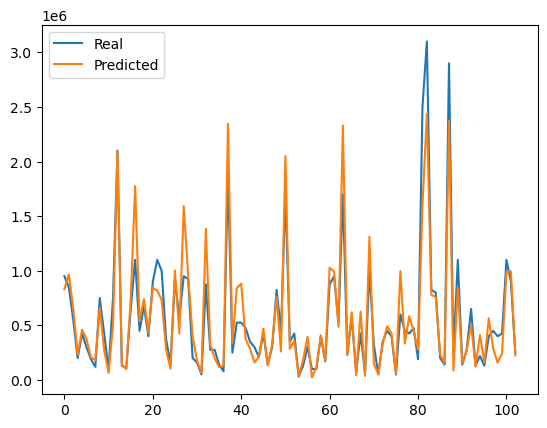

In [42]:
#if os.path.exists('lightGBM_model.txt'):
    #loaded_model = lgbm.Booster(model_file='lightGBM_model.txt')
    #model = lgbm.train(params, train_data, valid_sets=[eval_data], num_boost_round=500, init_model=loaded_model)
#else:
    #model = lgbm.train(params, train_data, valid_sets=[eval_data], num_boost_round=500)
    
model = lgbm.train(best_params_lgb, train_data, valid_sets=[eval_data], num_boost_round=500)    
y_pred_loaded = model.predict(X_test, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_loaded))
# R² score
r2 = r2_score(y_test, y_pred_loaded)
mae = mean_absolute_error(y_test, y_pred_loaded)

print('RMSE: ', rmse)
print('R² score: ', r2)
print('MAE: ', mae)

plt.plot(y_test.values.ravel(), label='Real')
plt.plot(y_pred_loaded, label='Predicted')
plt.legend()
plt.show()

# Spara den nya modellen
#model.save_model('lightGBM_model.txt')

RMSE:  390373.772544949
R² score:  0.5195436597210046
MAE:  292494.5437965139


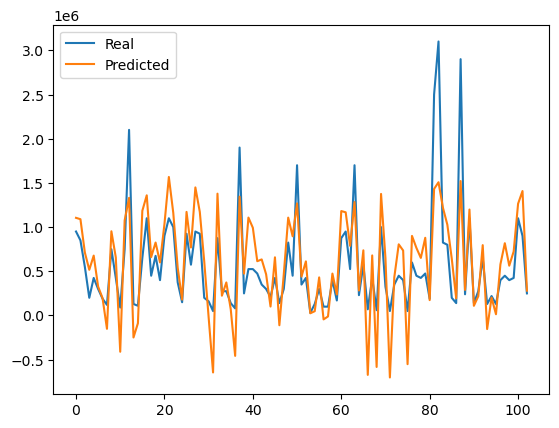

In [45]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

y_pred_test = linear_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

print('RMSE: ', rmse)
print('R² score: ', r2)
print('MAE: ', mae)

plt.plot(y_test.values.ravel(), label='Real')
plt.plot(y_pred_test, label='Predicted')
plt.legend()
plt.show()

RMSE:  221783.0600414588
R² score:  0.844922279671376
MAE:  105111.1383115898


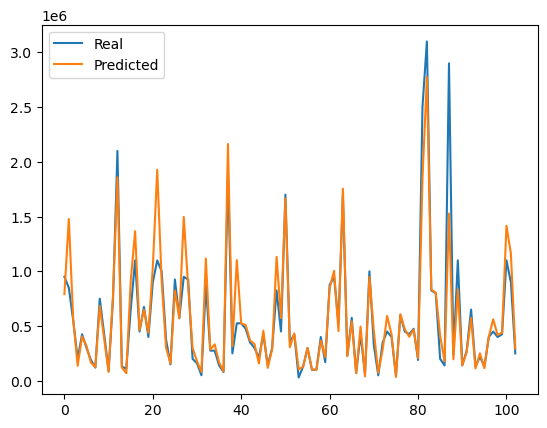

In [46]:
xgb_params = {
    'max_depth': best_params['model__max_depth'],
    'learning_rate': best_params['model__learning_rate'],
    'gamma': best_params['model__gamma'],
    'n_estimators': best_params['model__n_estimators'],
    'subsample': best_params['model__subsample'],
    'colsample_bytree': best_params['model__colsample_bytree']
}

# Create and train the XGBRegressor model with the extracted parameters
xgb_r = xgb.XGBRegressor(**xgb_params)
xgb_r.fit(X_train, y_train) 

# Make predictions
y_pred_test = xgb_r.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

# Print evaluation metrics
print('RMSE: ', rmse)
print('R² score: ', r2)
print('MAE: ', mae)

# Plot real vs predicted values
plt.plot(y_test.values.ravel(), label='Real')
plt.plot(y_pred_test, label='Predicted')
plt.legend()
plt.show()